In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [51]:
data_path = "/home/roger/Desktop/surprise-adaptive-agents/runs/runs"
exps = os.listdir(data_path)
reward_results = {}

key_to_plot = "ep_surprise" # could be "ep_return", "ep_length", "ep_surprise", "ep_entropy"

for exp in exps:
    if "MinAtar" in exp:
        continue
    
    if os.path.isdir(os.path.join(data_path, exp)):
        
        #join all words but the last _seed:1
        exp_name = "_".join(exp.split("_")[:-1])
        if exp_name not in reward_results:
            reward_results[exp_name] = []
            
        file = os.path.join(data_path, exp, "log.csv")
        reward_data = pd.read_csv(file)
        reward_results[exp_name].append(reward_data[key_to_plot])

        # for tetris, instead, overwrite the return with =1 if ep_length > 500 and =0 otherwise
        if "tetris" in exp and key_to_plot == "ep_return":
            reward_results[exp_name][-1] = (reward_data["ep_length"] > 100).astype(int)


In [52]:
# make sure for each key in results, all the lists of rewards in the key are of the same length (which should be the max length common to all)
min_lens = {}
for key in reward_results:
    min_len = min([len(x) for x in reward_results[key]])
    reward_results[key] = [x[:min_len] for x in reward_results[key]]
    min_lens[key] = min_len

In [53]:
# select only X points
num_points = 20
for key in reward_results.keys():
    try:
        reward_results[key] = np.array(reward_results[key])
        indices = np.linspace(0, reward_results[key].shape[1]-1, num_points, dtype=int)
        reward_results[key] = reward_results[key][:, indices]
    except:
        print(key)
        print(reward_results[key].shape)

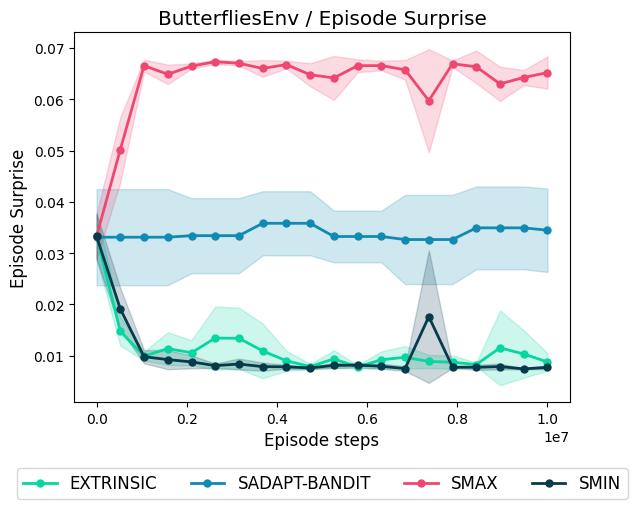

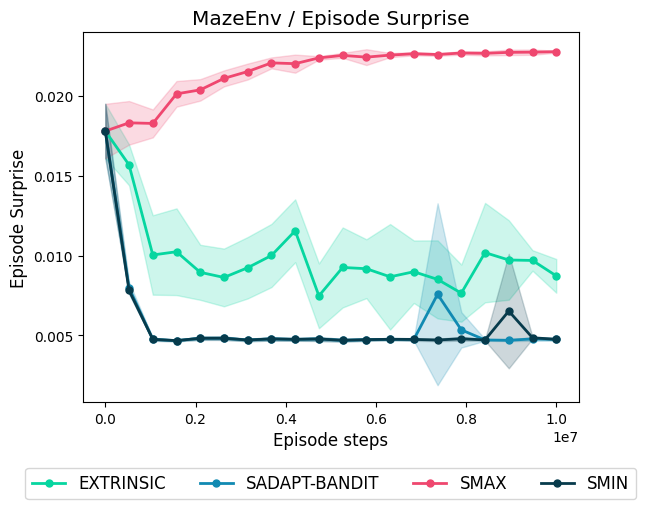

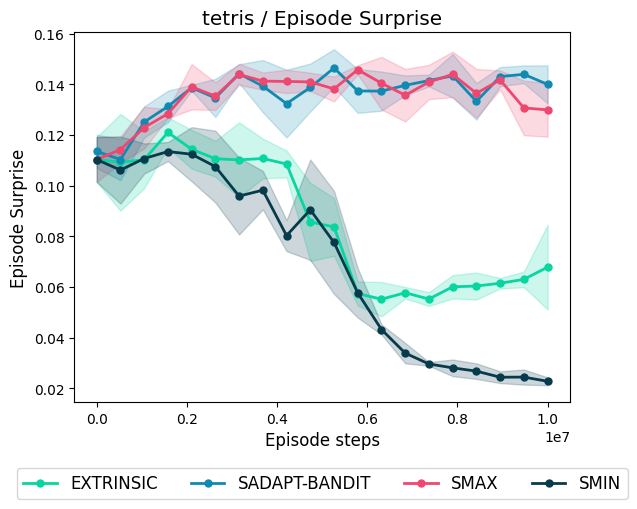

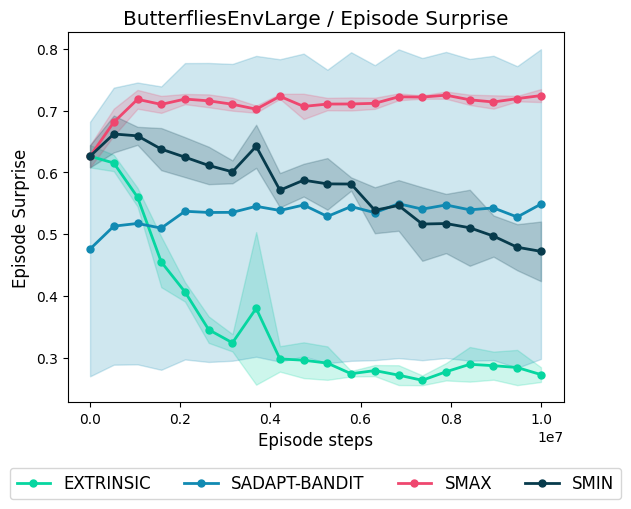

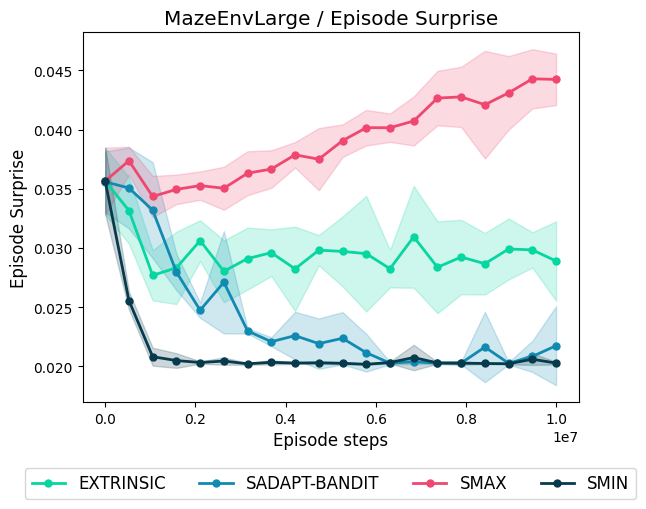

In [54]:
env_names = ["ButterfliesEnv", "MazeEnv", "tetris", "ButterfliesEnvLarge", "MazeEnvLarge"]
# one color for S-Max, S-Min, Extrinisc, S-Adapt
colors = ["#06d6a0", "#118ab2", "#ef476f", "#073b4c"]

for env in env_names:
    fig, ax = plt.subplots()
    idx_ = 0
    for exp in sorted(reward_results):
        # check if the env is in the exp name (MazeEnvLarge shouldnt be in MazeEnv for example)
        if env not in exp or (env == "MazeEnv" and "MazeEnvLarge" in exp) or (env == "ButterfliesEnv" and "ButterfliesEnvLarge" in exp):
            continue
        
        exp_name = exp.split("_")[2].upper()
        if exp_name == "NONE": exp_name = "EXTRINSIC"
        
        if key_to_plot == "ep_return":
            metric_title = "Episode Return"
        elif key_to_plot == "ep_surprise":
            metric_title = "Episode Surprise"
        elif key_to_plot == "ep_entropy":
            metric_title = "Episode Entropy"
        elif key_to_plot == "ep_length":
            metric_title = "Episode Length"
        else:
            raise ValueError("Invalid key_to_plot")
        
        env_title = env.capitalize()
        env_title = env_title.replace("Env", "")
        env_title = env + " / " + metric_title
        
        mean = reward_results[exp].mean(axis=0)
        std = reward_results[exp].std(axis=0)
        x_axis = np.linspace(0, 10_000_000, num_points)
        
        ax.plot(x_axis, mean, linewidth=2, marker='o', markersize=5, c=colors[idx_], label=exp_name)
        ax.fill_between(x_axis, mean+std, mean-std, alpha=0.2, color=colors[idx_])
        # put legend outside the plot. center bottom
        ax.legend(loc='center', bbox_to_anchor=(0.5, -0.22), ncol=4, fontsize="large")
        ax.set_title(env_title, fontsize="x-large")
        ax.set_xlabel("Episode steps", fontsize="large")
        ax.set_ylabel(metric_title, fontsize="large")
        idx_ += 1